In [70]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [71]:
crypto = "AUCTION"
df = pd.read_csv(f"data/{crypto}.csv")
df["timestamp"] = [int(datetime.timestamp(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))) for x in df["datetime"]]
df.set_index('timestamp', inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])

In [72]:
# Extract features and target
times = df.index.astype(int) // (90 * 10)
print(times)

Index([1889344, 1889345, 1889346, 1889347, 1889348, 1889349, 1889350, 1889351,
       1889352, 1889353,
       ...
       1891361, 1891362, 1891363, 1891364, 1891365, 1891366, 1891367, 1891368,
       1891369, 1891370],
      dtype='int32', name='timestamp', length=2027)


In [73]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['open', 'close', 'volume', 'high', 'low', 'hourly']
num_features = len(features)
df_scaled = scaler.fit_transform(df[features])

In [74]:
# Function to create input sequences and labels
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)


# Set the sequence length
sequence_length = 64

In [75]:
# Create sequences and labels
X, y = create_sequences(df_scaled, sequence_length)
print(X.shape)
print(y.shape)

(1963, 64, 6)
(1963, 6)


In [76]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(num_features))

model.compile(optimizer='adam', loss='mean_squared_error')

In [77]:
# Train the model
model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
62/62 [==============================] - 5s 26ms/step - loss: 0.0289
Epoch 2/20
62/62 [==============================] - 2s 31ms/step - loss: 0.0125
Epoch 3/20
62/62 [==============================] - 2s 32ms/step - loss: 0.0101
Epoch 4/20
62/62 [==============================] - 2s 33ms/step - loss: 0.0090
Epoch 5/20
62/62 [==============================] - 2s 34ms/step - loss: 0.0085
Epoch 6/20
62/62 [==============================] - 2s 32ms/step - loss: 0.0075
Epoch 7/20
62/62 [==============================] - 2s 35ms/step - loss: 0.0072
Epoch 8/20
62/62 [==============================] - 2s 34ms/step - loss: 0.0067
Epoch 9/20
62/62 [==============================] - 2s 33ms/step - loss: 0.0060
Epoch 10/20
62/62 [==============================] - 2s 33ms/step - loss: 0.0061
Epoch 11/20
62/62 [==============================] - 2s 34ms/step - loss: 0.0058
Epoch 12/20
62/62 [==============================] - 2s 30ms/step - loss: 0.0052
Epoch 13/20
62/62 [==================

In [78]:
# Make predictions
y_pred = model.predict(X)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_real = scaler.inverse_transform(y)

prediction_dict = {'datetime': df["datetime"][:-sequence_length], 'timestamp': times[:-sequence_length],
                   'real_price': y_real[:, 0], 'predicted_price': y_pred[:, 0]}
df_pred = pd.DataFrame.from_dict(prediction_dict)
df_pred['datetime'] = pd.to_datetime(df['datetime'])
df_pred['datetime'] += pd.Timedelta(sequence_length // 4, unit="h")
df_pred

62/62 [==============================] - 1s 11ms/step


,datetime,timestamp,real_price,predicted_price
timestamp,,,,
1700409600,2023-11-20 16:00:00,1889344,9.74,9.549863
1700410500,2023-11-20 16:15:00,1889345,9.77,9.611985
1700411400,2023-11-20 16:30:00,1889346,9.64,9.640496
1700412300,2023-11-20 16:45:00,1889347,9.64,9.638221
1700413200,2023-11-20 17:00:00,1889348,9.61,9.614152
...,...,...,...,...
1702171800,2023-12-11 01:30:00,1891302,16.63,16.440401
1702172700,2023-12-11 01:45:00,1891303,16.56,16.408569
1702173600,2023-12-11 02:00:00,1891304,16.56,16.391615


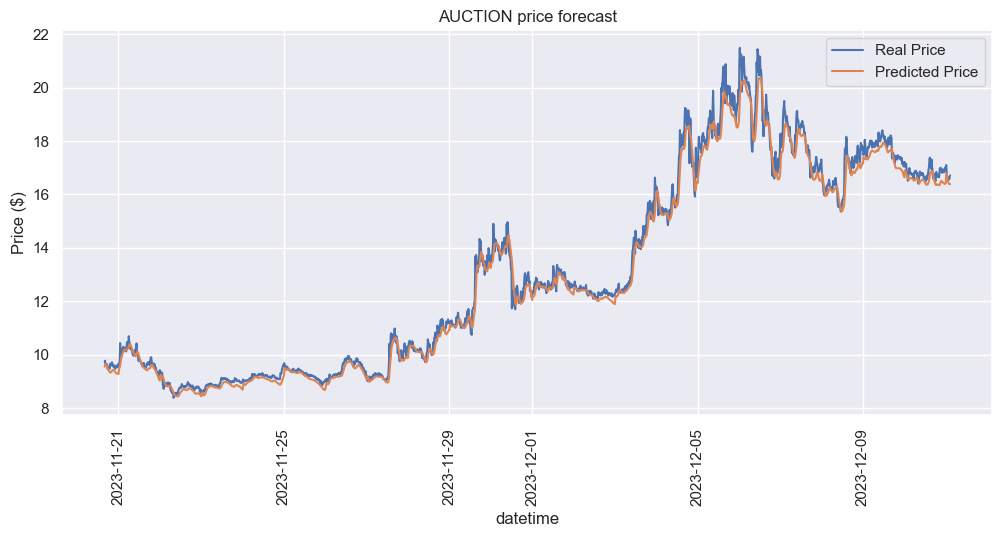

In [79]:
# Plot the results
plt.figure(figsize=(12, 5))
sns.lineplot(df_pred, x="datetime", y="real_price", label="Real Price")
sns.lineplot(df_pred, x="datetime", y="predicted_price", label="Predicted Price")
plt.ylabel("Price ($)")
plt.xticks(rotation=90)
plt.title(f"{crypto} price forecast")
plt.show()

1/1 [==============================] - 0s 23ms/step


[]

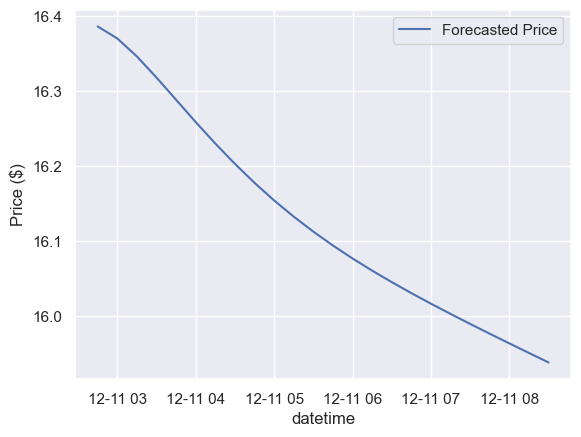

In [80]:
def forecast(data, futur):
    arr = np.expand_dims(data[-1], axis=0)
    #print(data.shape)
    #print(arr.shape)
    L = []
    for _ in range(futur):
        #print("[1]", arr.shape)
        prediction = model.predict(arr)
        #print("[2]", prediction.shape)
        prediction = prediction.reshape(1, 1, num_features)
        #print("[3]", prediction.shape)
        arr = np.append(arr, prediction, axis=1)
        #print("[4]", arr.shape)
        arr = np.delete(arr, 0, axis=1)
        #print("[5]", arr.shape)
        L.append(arr[0][-1])
    return np.array(L)


nb_time = 24
yForecast = forecast(X, nb_time)
yForecast = scaler.inverse_transform(yForecast)[:, 0]
xForecast = range(times[-1], times[-1] + nb_time)
datetime = pd.date_range(start=df["datetime"].values[-1], periods=nb_time + 1, freq='15T')[1:]

forecast_dict = {"datetime": datetime, "timestamp": xForecast, "forecasted_price": yForecast}

df_forecast = pd.DataFrame.from_dict(forecast_dict)
df_forecast['datetime'] = pd.to_datetime(df_forecast['datetime'])

sns.lineplot(df_forecast, x="datetime", y="forecasted_price", label="Forecasted Price")
plt.ylabel("Price ($)")
plt.plot()

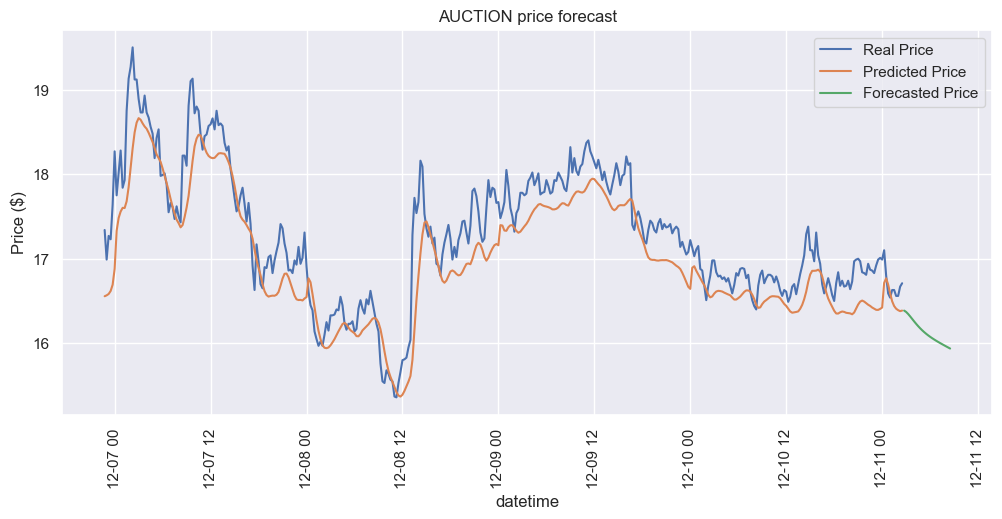

In [81]:
# Plot the results
plt.figure(figsize=(12, 5))
sns.lineplot(df_pred[-400:], x="datetime", y="real_price", label="Real Price")
sns.lineplot(df_pred[-400:], x="datetime", y="predicted_price", label="Predicted Price")
sns.lineplot(df_forecast, x="datetime", y="forecasted_price", label="Forecasted Price")
plt.ylabel("Price ($)")
plt.xticks(rotation=90)
plt.title(f"{crypto} price forecast")
plt.show()